<a href="https://colab.research.google.com/github/aamini/introtodeeplearning_labs/blob/2019/lab2/Lab2_Part2_Solutions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Laboratory 2 : Computer Vision

# Part 2: De-Biasing Facial Recognition Systems

In the second portion of this lab, we will explore two prominent aspects of applied deep learning: facial recognition systems and algorithmic bias. 

Deploying fair, unbiased AI systems is critical for long-term acceptance of these approaches. Consider the task of facial recognition: given an image, is it an image of a face? [Recent work from the MIT Media Lab](http://proceedings.mlr.press/v81/buolamwini18a/buolamwini18a.pdf) showed that this seemingly simple, but extremely important, task is subject to extreme amounts of algorithmic bias among select demographics. [Another report](https://ieeexplore.ieee.org/document/6327355) analyzed the face detection system used by the US law enforcement, and found that it had significantly lower accuracy among dark women between the age of 18-30 years old. Run the next code block for a short video from Joy B. that explains this notion of algorithmic bias:

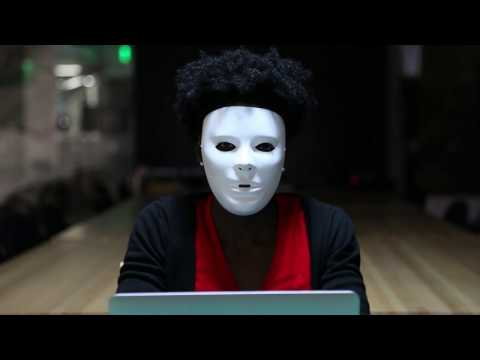

In [1]:
from IPython.display import YouTubeVideo
YouTubeVideo('162VzSzzoPs')

In this lab, we'll investigate one approach to address algorithmic bias by building a facial recognition model that learns the underlying *latent variables* in a dataset and uses this to adaptively re-sample the training data, mitigating any bias. This lab is based on a very recent paper in which this approach was originially proposed.   

Let's get started by installing the relevant dependencies:

In [0]:
# TODO: install dependencies

## 2.1 Datasets

We'll be using three datasets in this lab. In order to train our facial recognition models, we'll need a dataset of positive examples (i.e., of faces) and a dataset of negative examples (i.e., of things that are not faces). Finally, we'll need a test dataset of face images. Since we're concerned about the potential *bias* of our learned models against certain demographics, it's important that the test dataset we use has equal representation across the demographics or features of interest. We'll specifically be looking at skin tone and gender. 


1.   Positive training data: [CelebA Dataset](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html). A large-scale (over 200K images) of celebrity faces.   
2.   Negative training data: [ImageNet](http://www.image-net.org/). Many images across many different categories. We'll take negative examples from a variety of non-human categories. 
3. Test data: [Pilot Parliaments Benchmark](http://proceedings.mlr.press/v81/buolamwini18a/buolamwini18a.pdf) (PPB). Images of parliamentarians from three African countries and three European countries, selected for parity across gender and skin tone. 



Let's begin by importing these three datasets. We've written a function that does a bit of data pre-processing and imports these data for you :)

In [0]:
# TODO function to import the datasets in the appropriate format

To get a better sense of what's in each of these datasets, we can display some randomly selected images from each.

In [0]:
# TODO display images from the three datasets

As you can see, the PPB dataset is quite balanced in terms of the skin tone and gender across the set of displayed images. Do you notice any trends or patterns in the images from the CelebA dataset? Do you anticipate any potential issues in terms of classification performance for models trained on CelebA and then tested on a dataset like PPB?

### Thinking about bias

Remember that we'll be training facial detection classifiers on the large, well-curated CelebA dataset (and ImageNet), and then evaluate the *accuracy* and *bias* of our models across different demographics by testing them on the PPB dataset. Our goal is to build a model that trains on CelebA *and* achieves high classification accuracy on PPB across all demographics, and to show that this model does not suffer from algorithmic bias. 

What exactly do we mean if we say a classifier is biased? In order to formalize this, we'll need to think about [*latent variables*](https://en.wikipedia.org/wiki/Latent_variable), variables that define a dataset but are not strictly observed, which was introduced during the generative modeling lecture. We can think of a classifier as *biased* if its classification decision changes after it sees some additional latent features. This notion of bias will be helpful to keep in mind throughout the rest of the lab. 

## 2.2 CNN for facial detection 

First, we'll define and train a CNN on the facial classification task, and evaluate its accuracy on the PPB dataset. Later, we'll evaluate the performance of our debiased models against this baseline CNN. The model architecture is shown here:

![CNN model](https://raw.githubusercontent.com/aamini/introtodeeplearning_labs/2019/lab2/img/mnist_model.png)
TODO: update the architecture figure

### Define and train the CNN model

Like we did in the first part of the lab, we'll define our CNN model, and then train on the CelebA and ImageNet datasets using the `tf.GradientTape` class and the `tf.GradientTape.gradient` method:

In [0]:
# TODO: block here for defining the CNN model and running the training loop

We can examine the classification accuracy of our trained CNN on an independent validation set drawn from CelebA and also look at how the loss evolved as training progressed:

TODO: have an image of loss and validation accuracy here?

### Evaluate performance on the PPB dataset

Next, let's evaluate the classification performance of our CelebA-trained CNN on the PPB dataset. We'll look at the classification accuracy across four different demographics defined in PPB: dark-skinned male, dark-skinned female, light-skinned male, and light-skinned female.

In [0]:
# TODO: block here for testing the CNN on PPB
# include a function that returns / plots the accuracy on the four different demographics in PPB

Take a look at the accuracies for this first model across these four groups. What do you observe? Would you consider this model biased or unbiased, and why? 

## 2.3 Variational autoencoder (VAE) for learning latent structure

As you saw, the accuracy of the CNN varies across the four demographics we looked at, performing worse on images of dark-skinned males in particular. To think about why  let's consider the dataset the model was trained on, CelebA. If certain features, such as dark skin or hats, are *rare* in CelebA, the model may end up biased against these; that is, it's classification accuracy will be worse on dark-skinned faces or faces with hats. This is a problem. 

TODO: insert schematic image here?

To debias our classifier, we'll train a model that learns the latent features underlying the faces in the training set, and then uses this information to mitigate unwanted biases by sampling faces with rare features, like dark skin or hats, *more frequently *while it trains. So, our model needs to learn an *encoding* of the latent features in an entirely unsupervised way -- we'll turn to a variational autoencoder (VAE):

![The concept of a VAE](http://kvfrans.com/content/images/2016/08/vae.jpg)

TODO: change the VAE architecture

VAEs rely on this encoder-decoder structure. The encoder takes in the input images, encodes them into a series of variables defined by a mean and standard deviation, and then samples from these to generate a set of sampled latent variables. The decoder then "decodes" these variables to generate a reconstruction of the original image, which is used during training to help the model learn which latent variables are important. 

### Define and train the VAE model

We'll build our VAE model by defining the encoder, which will consist of a series of convolutional layers like our standard CNN, and the decoder, which will consist of a series of deconvolutional layers that will lead to a reconstruction of the input image. 

In [0]:
# TODO code block for defining the VAE

As with our CNN model, we'll train our VAE on the facial classification task using the CelebA dataset as positive examples and images drawn from ImageNet as negative examples.

Complete and execute the training loop to train the VAE!

In [0]:
# TODO code block for training the VAE on celebA/ImageNet

### What latent variables did the VAE learn?

To get a better sense of what the VAE is learning, we can perturb the value of a single learned variable individually, and output the reconstructed faces resulting from each of these perturbations. This gives us the reconstructed output of the VAE along the gradient of a single latent variable. 

Run the code block below to examine some of the learned latent features!

In [0]:
# TODO
# Either have a block for face reconstruction slider
# Or can just have images (already outputted) for perturbations for a few latent variables

Hopefully you were able to observe that the VAE is able to learn qualitative features in the face dataset such as skin tone, hair, and gaze direction (azimuth). This examination gives us a sense of the types of features that our model will learn to debias against.

## 2.4 Debiasing variational autoencoder (DB-VAE) for facial detection

### The DB-VAE architecture

Now, we're ready to use the latent variables learned by a VAE to adaptively re-sample the CelebA data during the training operation. Specifically, we will alter the probability that a given image is sampled during training based on how often its features appear in the dataset. So, faces with rarer features (like dark skin, sunglasses, or hats) should be more likely to be sampled during training. The resulting model is termed a *debiasing variational autoencoder*, or DB-VAE:

![DB-VAE](https://raw.githubusercontent.com/aamini/introtodeeplearning_labs/2019/lab2/img/DB-VAE.png)

TODO: caption for the image

The network architecture of the DB-VAE is very similar to the VAE model we worked with earlier, and the encoder uses the same convolutional architecture as our CNN from earlier!

Note how the encoder portion learns a single supervised variable, *z0*, corresponding to the classification prediction--face or not face. Keep in mind that we only want to learn the latent representation of *faces*, as that's what we're ultimately debiasing against. So, our DB-VAE model will only learn unsupervised latent variables for the images of faces in addition to outputting the supervised classification prediction *z0*, but will instead only output *z0* for the negative examples. 



Now we're ready to define the DB-VAE architecture:

In [0]:
# TODO code block to define/build DB-VAE

### Adaptive resampling for automated debiasing with DB-VAE

Let's think a bit more about the math behind the described resampling operation. As shown above, as the input images are fed through the network, the encoder learns an estimate *Q(z|X)* of the latent distribution. We want to increase the relative frequency of rare data by increased sampling of under-represented regions of the latent space. So, we'll approximate *Q(z|X)* using the frequency distributions of each of the learned latent variables, and then use this approximation to define the probability distribution of selecting a given datapoint *x*. These probability distributions will be used during training to re-sample the data.

TODO: define math here? Possible to have equation text within text block of notebook?


Complete the code block below to define the resampling algorithm within the DB-VAE training loop. 

In [0]:
# TODO code block for the DB-VAE training operation with the resampling/de-biasing algorithm

Great! Now let's train our debiased model using our CelebA/ImageNet training data. Note that we only want to debias for features relevant to *faces*, not the set of negative examples. So, we will not learn a set of unsupervised latent variables for the negative examples, and instead output a single supervised variable reflecting the classification prediction (face vs. not face).

In [0]:
# TODO function call for the DB-VAE training operation.

As a check, we can examine the loss and classification accuracy for our debiased DB-VAE model on an independent validation set drawn from CelebA, and compare these to our biased CNN model:

In [0]:
# TODO code block for evaluating on validation set and plotting? 
# not sure if this is necessary????

![loss](https://raw.githubusercontent.com/aamini/introtodeeplearning_labs/2019/lab2/img/loss_val-acc.png)

TODO: example image, decide if actually want to show a plot like this

## 2.4 Evaluation on Pilot Parliaments Benchmark (PPB) Dataset

Now we're finally ready to test our debiased DB-VAE model on the[ PPB dataset](http://proceedings.mlr.press/v81/buolamwini18a/buolamwini18a.pdf). The PPB dataset consists of images of 1270 male and female parliamentarians from various African and European countries and exhibits parity in both skin tone and gender. The gender of each face is annotated with the sex-based "Male'' and "Female'' labels. Skin tone annotations are based on the Fitzpatrick skin type classification system, with each image labeled as "Lighter'' or "Darker''.

We'll evaluate both the overall accuracy of the DB-VAE as well as its accuracy on each the "Dark Male", "Dark Female", "Light Male", and "Light Female" demographics, and compare the performance of this debiased model against the biased CNN from earlier in the lab. 

Here are some example faces and average faces from the PPB dataset:
![PPB Example Images](https://raw.githubusercontent.com/aamini/introtodeeplearning_labs/2019/lab2/img/PPB%20faces.png)

To assess the performance of our models, we'll consider the classification accuracy, which we define as the fraction of faces detected in the PPB dataset by a given model. By comparing the accuracy of a model without debiasing and our DB-VAE model, we can get a sense of how effectively we were able to debias against features like skin tone and gender.


Let's evaluate each of the standard CNN and our debiased DB-VAE on the PPB test dataset:

In [0]:
# TODO code block to run the evaluation of the CNN and the DB-VAE on PPB dataset

We can calculate the accuracies of our two models on the whole PPB dataset as well as across the four demographics proposed:

In [0]:
# TODO code block to calculate the accuracies, and to plot the result in bar graph

We can visualize these results to enable a direct comparison: 

TODO generate bar graph and insert, should look like something else, but difference should be clear. this is something the students could do on their own as well. 

In [0]:
# TODO plot the accuracy bar graph for the two models on PPB, across the 4 demographics

In [0]:
# TODO generate a table showing the accuracies for the 4 demographics for each model

## 2.5 Conclusion 

We encourage you to think about and maybe even address some questions raised by the approach and results outlined here:

*  How does the accuracy of the DB-VAE across the four demographics compare to that of the standard CNN? Do you find this result surprising in any way?
*  In which applications (either related to facial detection or not!) would debiasing in this way be desired? Are there applications where you may not want to debias your model? 
* Do you think it should be necessary for companies to demonstrate that their models, particularly in the context of tasks like facial detection, are not biased? If so, do you have thoughts on how this could be standardized and implemented?
* Do you have ideas for other ways to address issues of bias, particularly in terms of the training data?

Hopefully this lab has shed some light on a few concepts, from vision based tasks, to VAEs, to algorithmic bias. We like to think it has, but we're biased ;). 

![Faces](https://media1.tenor.com/images/44e1f590924eca94fe86067a4cf44c72/tenor.gif?itemid=3394328)